In [1]:
from os import getcwd
import pandas as pd

from math import log
from os import getcwd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
def output_galaxies(galaxy_classification, label, sizes):
    """ Esta funcion se encarga de plotear la relación entre z y masa de los
    diferentes galaxias de cada grupo de masas. Creara un fichero de la forma:
    - galaxias_{valor_inferior}_{valor_superior}.png
    
    Devolverá los valores ploteados en forma de lista.

    @param galaxy_classification: valor en masa de la galaxia.
    @param label: etiqueta del plot a generar
    @param sizes: tamaño del plot. Este parametro no es automatizable y
    dependera del rango de masas elegido.

    @return
    """
    total_log_redshift_list = []
    total_log_mass_list = []

    data_dir = f'{getcwd()}/datos/{galaxy_classification}.csv'
    data = pd.read_csv(data_dir, error_bad_lines=False)

    fig, ax = plt.subplots(figsize=(11.69, 8.27))

    # Valores iniciales
    redshift_list = []
    mass_list = []
    final_mass = 0.0  # ¿Es realmente necesario?
    lastProgenitorId = 'ERROR'

    try:
        for idx, row in data.iterrows():
            # Comprueba si estamos en la primera posicion
            if int(row['snapnum']) == 63:
                # La longitud de la lista de datos es distinta de cero asi
                # que ya hemos ploteado otras lineas
                if len(redshift_list) != 0:
                    # Ploteamos los valores que tenemos
                    # Para facilitar la identificacion de la curva asignamos
                    # el id del ultimo progenitor como etiqueta de la misma
                    ax.plot(redshift_list, mass_list, label=lastProgenitorId)
                    # Los reiniciamos a cero
                    redshift_list = []
                    mass_list = []
                # Iniciamos un nuevo ciclo
                # Comprobamos el valor de la primera posicion
                # Si es distinta de cero la agregamos como la masa final
                if float(row['stellarMass']) != 0.0:
                    # Asigno el valor como masa final de la galaxia
                    final_mass = float(row['stellarMass'])
                # La masa estelar inicial es igual a cero
                # Necesitamos el primer valor no igual a cero, supondremos que
                # los valores anteriores son los mismos
                else:
                    final_mass_idx = idx
                    # Recorro todos los valores hasta encontrar el primer valor
                    # correcto
                    while data['stellarMass'].iloc[final_mass_idx] == 0.0:
                        final_mass_idx = final_mass_idx + 1
                    # Asigno el valor como masa final de la galaxia
                    final_mass = float(data['stellarMass'].iloc[final_mass_idx])
                if final_mass != 0.0:
                    # Agrega los datos a la lista total
                    total_log_redshift_list.append(log(1+row['redshift']))
                    total_log_mass_list.append(log(row['stellarMass']/final_mass))

                    redshift_list.append(log(1+row['redshift']))
                    mass_list.append(log(row['stellarMass']/final_mass))
                else:
                    raise Exception('Siempre deberia ser cero')
                # Hemos empezado un nuevo ciclo asi que guardo el valor
                # identificativo apra cuando toque dibujarlo
                lastProgenitorId = int(row['lastProgenitorId'])
            # No estamos en la primera posicion
            # Agrega los valores si no hay valores nulos
            else:
                if row['stellarMass'] != 0.0 and row['redshift'] != 0.0:
                    total_log_redshift_list.append(log(1+row['redshift']))
                    total_log_mass_list.append(log(row['stellarMass']/final_mass))

                    redshift_list.append(log(1+row['redshift']))
                    mass_list.append(log(row['stellarMass']/final_mass))
                else:
                    pass
    except Exception as e:
        print(galaxy_classification)
        print(str(e))

    # Fija la etiqueta principal
    ax.set_title(label)
    # Fija las etiquetas por eje
    ax.set_xlabel(r'$\log [1+Z]$')
    ax.set_ylabel(r'$\log[M_{main} (z) / M_0]$')
    # Crea el grid
    ax.grid(True)

    # Si se quiere probar la salida de redshift y masa poner a True
    # Creará un fichero csv con los datos de cada grupo de masa
    test = False
    if test:
        test_dict = {'redshift': total_log_redshift_list, 
                     'mass': total_log_mass_list}
        test_df = pd.DataFrame(test_dict)
        test_df.to_csv(f'{galaxy_classification}.csv')

    # Realiza el ajuste
    test_fit = np.polyfit(total_log_redshift_list, total_log_mass_list, 3)

    # Genera un conjunto de puntos entre el valor minimo y maximo de redshift
    x = np.arange(min(total_log_redshift_list), max(total_log_redshift_list))
    x = np.arange(0.0, 2.75, 0.05, dtype=float)

    # Ajuste de los puntos
    fit = np.poly1d(test_fit) 

    x_fit = [x_fit_value for x_fit_value in fit(x) if x_fit_value > -9.0]

    # Plotea los puntos
    ax.plot(x[:len(x_fit)], x_fit, "--", label="ajuste")

    x_ticks = np.arange(sizes['x'][0], sizes['x'][1], sizes['x'][2])
    y_ticks = np.arange(sizes['y'][0], sizes['y'][1], sizes['y'][2])

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    
    # Genera la leyenda
    plt.legend()
    # Guarda la figura
    plt.savefig(f'{getcwd()}/graficas/{galaxy_classification}.png', dpi=144)

    return [galaxy_classification, x, fit(x)]

In [3]:
def output_halos(halo_classification, label, sizes):
    """ Esta funcion se encarga de plotear la relación entre z y masa de los
    diferentes halos de cada grupo de masas. Creara un fichero de la forma:
    - halos_{valor_inferior}_{valor_superior}.png

    @param halo_classification: valor en masa de la galaxia.
    @param label: etiqueta del plot a generar
    @param sizes: tamaño del plot. Este parametro no es automatizable y
    dependera del rango de masas elegido.

    @return
    """
    total_log_redshift_list = []
    total_log_mass_list = []
    total_last_progenitor_id_list = []
    total_m_Crit200_list = []
    total_redshift_list = []

    data_dir = f'{getcwd()}/datos/{halo_classification}.csv'
    data = pd.read_csv(data_dir)

    fig, ax = plt.subplots(figsize=(11.69, 8.27))

    # Valores iniciales
    redshift_list = []
    mass_list = []
    final_mass = 0.0
    lastProgenitorId = 'ERROR'

    try:
        for idx, row in data.iterrows():
            # Comprueba si estamos en la primera posicion
            if int(row['snapNum']) == 63:
                # La longitud de la lista de datos es distinta de cero asi
                # que ya hemos ploteado otras lineas
                if len(redshift_list) != 0:
                    # Ploteamos los valores que tenemos
                    # Para facilitar la identificacion de la curva asignamos
                    # el id del ultimo progenitor como etiqueta de la misma
                    ax.plot(redshift_list, mass_list, label=lastProgenitorId)
                    redshift_list = []
                    mass_list = []
                # Iniciamos un nuevo ciclo
                # Comprobamos el valor de la primera posicion
                # Si es distinta de cero la agregamos como la masa final
                if float(row['m_Crit200']) != 0.0:
                    # Asigno el valor como masa final de la galaxia
                    final_mass = float(row['m_Crit200'])
                # La masa estelar inicial es igual a cero
                # Necesitamos el primer valor no igual a cero, supondremos que
                # los valores anteriores son los mismos
                else:
                    raise Exception
                if final_mass != 0.0:
                    redshift_list.append(log(1+row['redshift']))
                    mass_list.append(log(row['m_Crit200']/final_mass))

                    total_log_redshift_list.append(log(1+row['redshift']))
                    total_log_mass_list.append(log(row['m_Crit200']/final_mass))
                    total_redshift_list.append(row['redshift'])
                    total_m_Crit200_list.append(row['m_Crit200'])
                    total_last_progenitor_id_list.append(lastProgenitorId)
                else:
                    raise Exception('Siempre deberia ser cero')
                # Hemos empezado un nuevo ciclo asi que guardo el valor
                # identificativo apra cuando toque dibujarlo
                lastProgenitorId = int(row['lastProgenitorId'])
            # No estamos en la primera posicion
            # Agrega los valores si no hay valores nulos
            else:
                if row['m_Crit200'] != 0.0 and row['redshift'] != 0.0:
                    total_log_redshift_list.append(log(1+row['redshift']))
                    total_log_mass_list.append(log(row['m_Crit200']/final_mass))
                    total_redshift_list.append(row['redshift'])
                    total_m_Crit200_list.append(row['m_Crit200'])
                    total_last_progenitor_id_list.append(lastProgenitorId)

                    redshift_list.append(log(1+row['redshift']))
                    mass_list.append(log(row['m_Crit200']/final_mass))
    except Exception as e:
        print(halo_classification)
        print(str(e))

    # Fija la etiqueta principal
    ax.set_title(label)
    # Fija las etiquetas por eje
    ax.set_xlabel(r'$\log [1+Z]$')
    ax.set_ylabel(r'$\log[M_{main} (z) / M_0]$')
    # Crea el grid
    ax.grid(True)
    
    # Si se quiere probar la salida de redshift y masa poner a True
    # Creará un fichero csv con los datos de cada grupo de masa
    test = True
    if test:
        test_dict = {'log_redshift': total_log_redshift_list, 
                     'log_mass': total_log_mass_list}
        test_df = pd.DataFrame(test_dict)
        test_df.to_csv(f'{getcwd()}/datos_filtrados/{halo_classification}.csv')

    # Realiza el ajuste
    test_fit = np.polyfit(total_log_redshift_list, total_log_mass_list, 3)

    # Genera un conjunto de puntos entre el valor minimo y maximo de redshift
    x = np.arange(min(total_log_redshift_list), max(total_log_redshift_list))
    x = np.arange(0.0, 2.75, 0.05, dtype=float)

    # Ajuste de los puntos
    fit = np.poly1d(test_fit)

    x_fit = [x_fit_value for x_fit_value in fit(x) if x_fit_value > -8.0]

    # Plotea los puntos
    ax.plot(x[:len(x_fit)], x_fit, "--", label="ajuste")
    
    y_ticks = np.arange(sizes['y'][0], sizes['y'][1], sizes['y'][2])
    x_ticks = np.arange(sizes['x'][0], sizes['x'][1], sizes['x'][2])

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # Genera la leyenda
    plt.legend()
    # Guarda la figura
    plt.savefig(f'{getcwd()}/graficas/{halo_classification}.png', dpi=144)

    return [halo_classification, x, fit(x)]

In [4]:
# Rutina principal para crear las gráficas
def main(galaxies, halos):
    if halos:
        fitted_groups = []
        # Nombre de los ficheros de los halos
        halos_classification = ['halos_10', 'halos_10_11','halos_11_12',
                                'halos_12_13', 'halos_13']

        # Etiquetas de las graficas de los halos
        halos_label = [r'Halos < ' + r'$10^{10}$',
                    r'$10^{10}$' + ' < Halos < ' + r'$10^{11}$',
                    r'$10^{11}$' + ' < Halos < ' + r'$10^{12}$',
                    r'$10^{12}$' + ' < Halos < ' + r'$10^{13}$',
                    r'Halos > ' + r'$10^{13}$',]

        # Tamaño de las graficas de los halos
        halos_size = [{'x': [-0.25, 3.25, 0.25], 'y': [-9.5, 2, 0.5]},
                    {'x': [-0.25, 3.25, 0.25], 'y': [-9.5, 2, 0.5]},
                    {'x': [-0.25, 3.25, 0.25], 'y': [-9.5, 2, 0.5]},
                    {'x': [-0.25, 3.25, 0.25], 'y': [-9.5, 2, 0.5]},
                    {'x': [-0.25, 3.25, 0.25], 'y': [-9.5, 2, 0.5]}]

        # Bucle for para crear las graficas de los halos
        try:
            for idx, halo_classification in enumerate(halos_classification):
                output = output_halos(halo_classification, halos_label[idx],
                halos_size[idx])
                fitted_groups.append(output)
        except Exception as e:
            print(str(e))

        # Bucle for para crear la gráfica con los ajustes
        import matplotlib.pyplot as plt
        fig2, ax_total = plt.subplots(figsize=(11.69, 8.27))
        for group in fitted_groups[1:]:
            ax_total.plot(group[1], group[2], label=group[0])

        ax_total.set_title('Ajuste por masa')

        ax_total.set_xlabel(r'$\log [1+Z]$')
        ax_total.set_ylabel(r'$\log[M_{main} (z) / M_0]$')

        ax_total.grid(True)

        x_ticks = np.arange(-0.25, 3.25, 0.25)
        y_ticks = np.arange(-9.5, 2, 0.5)

        ax_total.set_xticks(x_ticks)
        ax_total.set_yticks(y_ticks)
        
        plt.legend()
        plt.savefig(f'{getcwd()}/graficas/halos_ajuste.png', dpi=144)

    if galaxies:
        fitted_groups = []
        # Nombre de los ficheros de las galaxias
        galaxies_classification = ['galaxias_10', 'galaxias_10_11',
                                'galaxias_11_12', 'galaxias_12_13',
                                'galaxias_13']

        # Etiquetas de las gráficas de las galaxias
        galaxies_label = [r'Galaxias < ' + r'$10^{10}$',
                        r'$10^{10}$' + ' < Galaxias < ' + r'$10^{11}$',
                        r'$10^{11}$' + ' < Galaxias < ' + r'$10^{12}$',
                        r'$10^{12}$' + ' < Galaxias < ' + r'$10^{13}$',
                        r'Galaxias > ' + r'$10^{13}$']

        # Tamaño de las gráficas de las galaxias
        galaxies_size = [{'x': [-0.25, 3.25, 0.25], 'y': [-12, 1, 0.5]},
                        {'x': [-0.25, 3.25, 0.25], 'y': [-12, 1, 0.5]},
                        {'x': [-0.25, 3.25, 0.25], 'y': [-12, 1, 0.5]},
                        {'x': [-0.25, 3.25, 0.25], 'y': [-12, 1, 0.5]},
                        {'x': [-0.25, 3.25, 0.25], 'y': [-12, 1, 0.5]}]

        # Bucle for para crear las graficas de las galaxias
        try:
            for idx, galaxy_classification in enumerate(galaxies_classification):
                output = output_galaxies(galaxy_classification,
                                         galaxies_label[idx], 
                                         galaxies_size[idx])
                fitted_groups.append(output)
        except Exception as e:
            print(str(e))

        # Bucle for para crear la gráfica con los ajustes
        import matplotlib.pyplot as plt
        fig2, ax_total = plt.subplots(figsize=(11.69, 8.27))
        for group in fitted_groups[1:]:
            y_values = [x_value for x_value in group[2] if x_value > -11.5]
            ax_total.plot(group[1][:len(y_values)], y_values, label=group[0])

        ax_total.set_title('Ajuste por masa')

        ax_total.set_xlabel(r'$\log [1+Z]$')
        ax_total.set_ylabel(r'$\log[M_{main} (z) / M_0]$')

        ax_total.grid(True)

        x_ticks = np.arange(-0.25, 3.25, 0.25)
        y_ticks = np.arange(-12, 1, 0.5)

        ax_total.set_xticks(x_ticks)
        ax_total.set_yticks(y_ticks)

        plt.legend()
        plt.savefig(f'{getcwd()}/graficas/galaxias_ajuste.png', dpi=144)

b'Skipping line 450: expected 62 fields, saw 63\n'


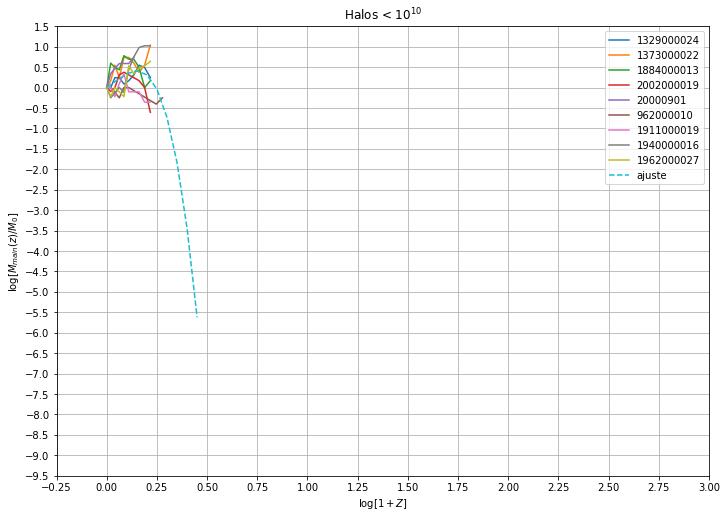

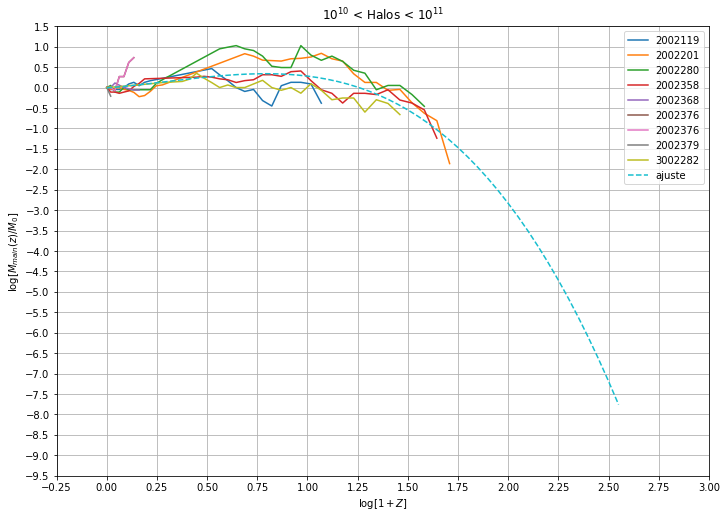

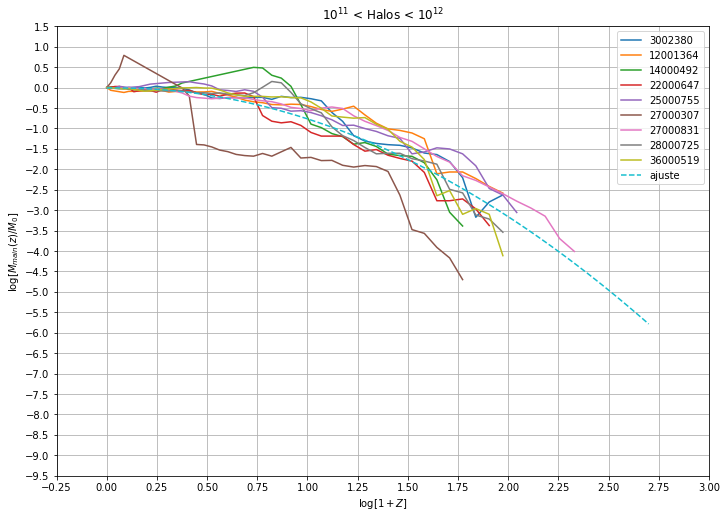

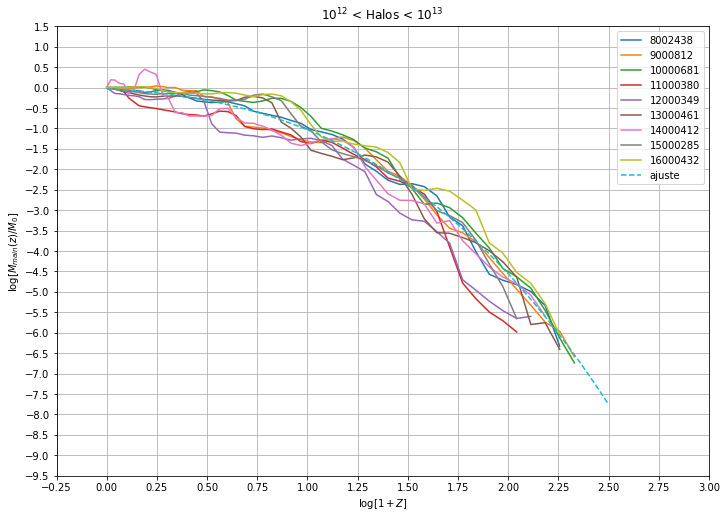

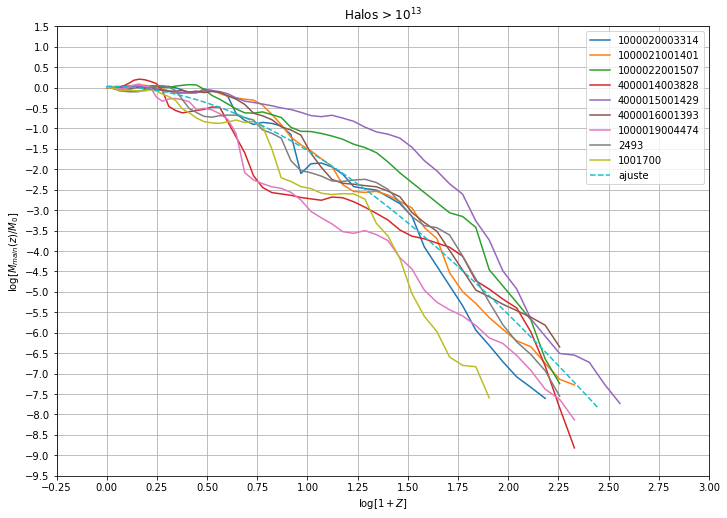

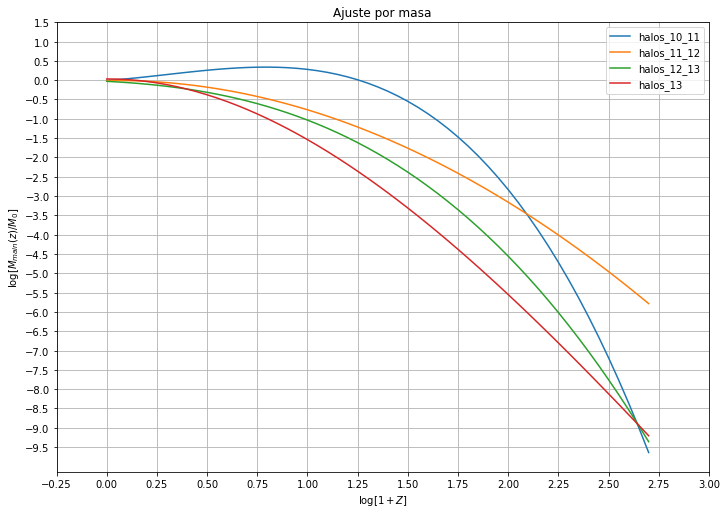

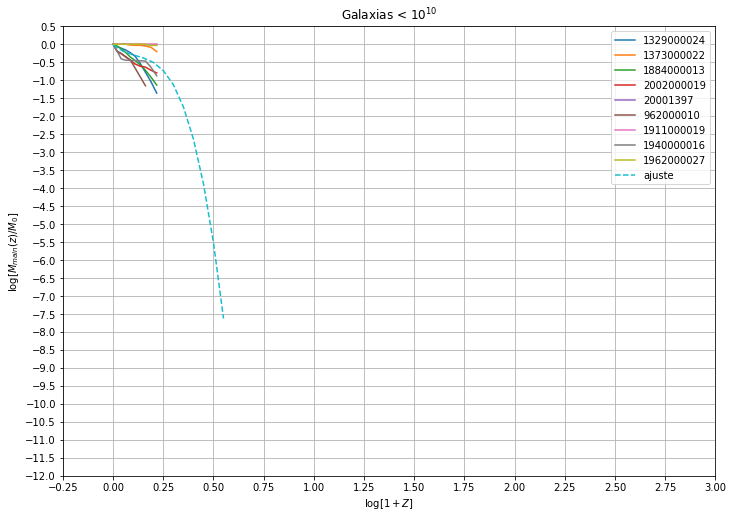

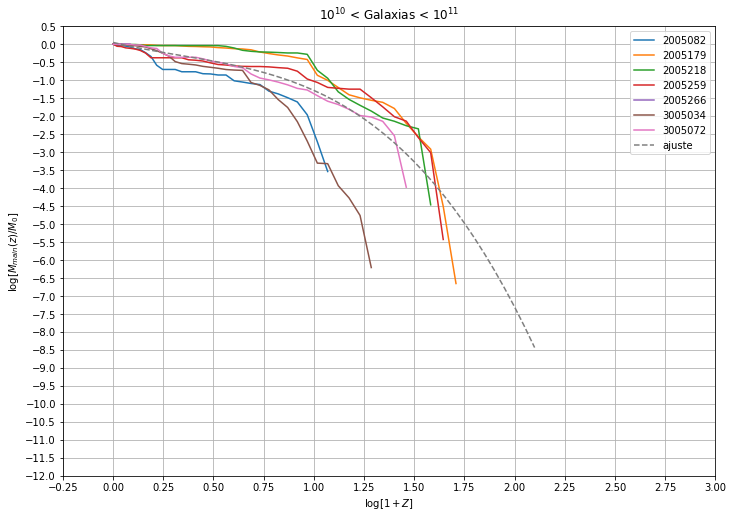

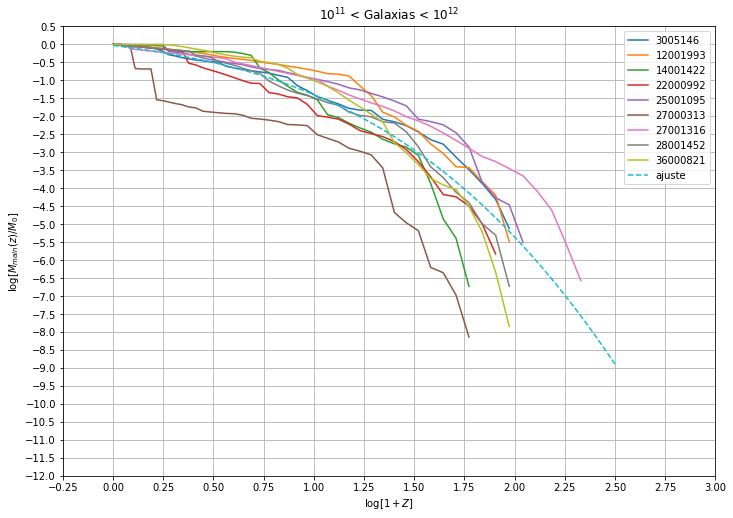

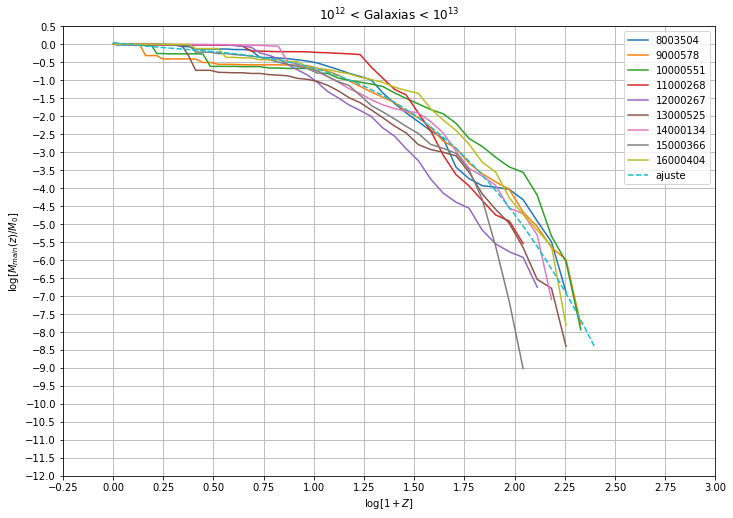

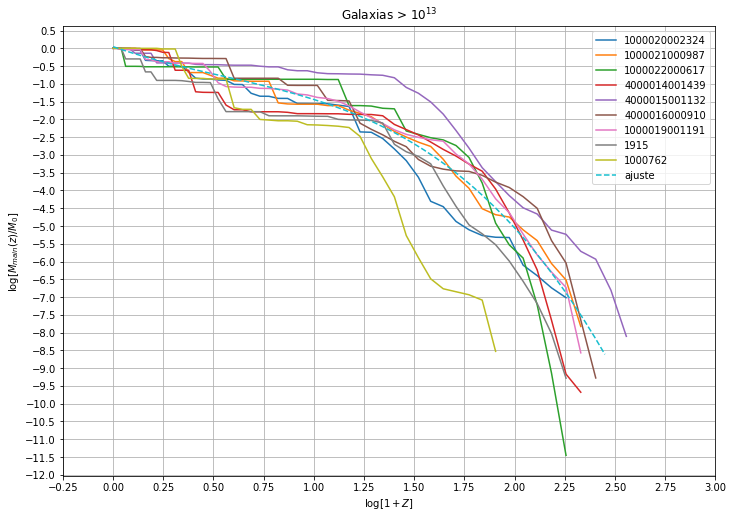

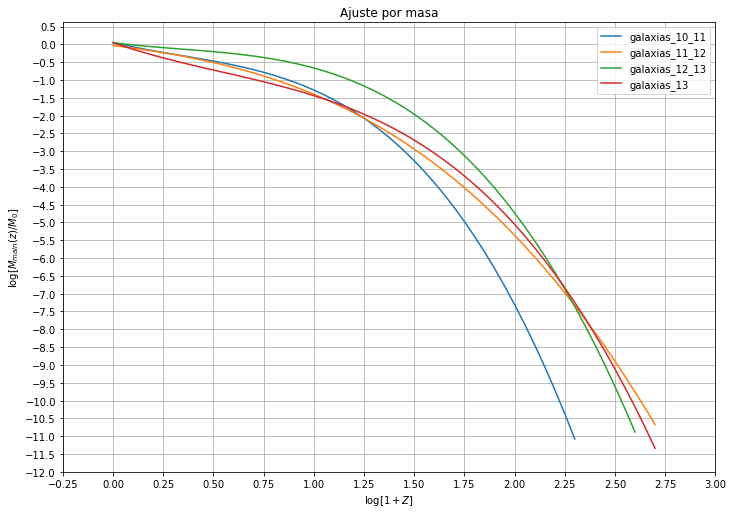

In [5]:
if __name__ == "__main__":
    galaxies = True
    halos = True
    main(galaxies, halos)